In [1]:
from glob import glob
import pandas as pd

In [5]:
len(glob('../splited_dataset/train/*/'))

48

In [6]:
df=pd.DataFrame([[i.split('\\')[-2],len(glob(i+'*.jpg'))] for i in glob('../splited_dataset/train/*/')])
df.to_clipboard()

In [7]:
df.iloc[:,1].sum()

3103

In [8]:
import random
from PIL import Image
import matplotlib.pyplot as plt
labels,images=[],[]
for label_path in glob('../splited_dataset/train/*/'):
    labels.append(label_path.split('\\')[-2])
    image=random.choice(glob(label_path+'*.jpg'))
    images.append(Image.open(image))
    

In [9]:
48/4

12.0

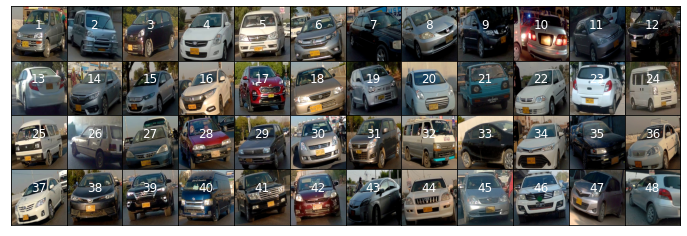

In [19]:
fig,ax=plt.subplots(ncols=12,nrows=4,figsize=(12,8))
imc=0
for i in range(4):
    for j in range(12):
        img=images[imc].resize((224,224))
        ax[i,j].imshow(img)
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        ax[i,j].set_title(imc+1,color='w',y=0.5)
        imc+=1
plt.subplots_adjust(wspace=0, hspace=-0.8)
plt.savefig('cars.eps',bbox_inches='tight')

In [1]:
#grad cam resnet

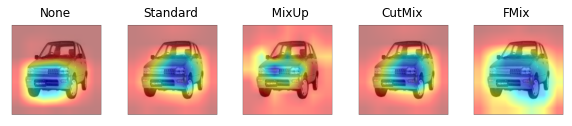

In [9]:
from PIL import Image
from glob import glob
import matplotlib.pyplot as plt
noaug=Image.open('../images/cam/resnet/noaug.png')
stdaug=Image.open('../images/cam/resnet/cutmix.png')
mixup=Image.open('../images/cam/resnet/resmixup.png')
cutmix=Image.open('../images/cam/resnet/cutmix.png')
fmix=Image.open('../images/cam/resnet/resfmix.png')
augs=[noaug,stdaug,mixup,cutmix,fmix]
names=['None','Standard', '  MixUp','CutMix','FMix']
fig,ax=plt.subplots(1,5,figsize=(10,8))
for i in range(5):
    ax[i].imshow(augs[i])
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_title(names[i])
    ax[i].set_frame_on(False)
plt.savefig('../images/cam/resnet/cam.png',bbox_inches='tight')
plt.savefig('../images/cam/resnet/cam.eps',bbox_inches='tight')

# gradcam

In [ ]:
import numpy as np
from pytorch_lightning import seed_everything, LightningModule, Trainer
from sklearn.utils import class_weight
import torch.nn as nn
import torch
from torch.utils.data.dataloader import DataLoader
from pytorch_lightning.callbacks import EarlyStopping,ModelCheckpoint,LearningRateMonitor
from torch.optim.lr_scheduler import CyclicLR, ReduceLROnPlateau,CosineAnnealingWarmRestarts,OneCycleLR,LambdaLR
import torchvision
from sklearn.metrics import classification_report,f1_score,accuracy_score
import matplotlib.pyplot as plt
import random
from pytorch_grad_cam import GradCAM,GradCAMPlusPlus,XGradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
np.random.seed(2021)
random.seed(0)

In [ ]:
import pandas as pd
from glob import glob
df=pd.DataFrame([[i.split('\\')[-2],len(glob(i+'*.jpg'))] for i in glob('splited_dataset/test/*/')])
df.head()

In [ ]:
#https://discuss.pytorch.org/t/using-imagefolder-random-split-with-multiple-transforms/79899/4
from torch.utils.data import DataLoader, Dataset
img_size=224
class MyLazyDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        x=self.dataset[index][0]
        y=self.dataset[index][1]
        if self.transform:
            #x = self.transform(x)
            x=np.array(x)
            x=self.transform(image=x)['image']
        return x, y
    
    def __len__(self):
        return len(self.dataset)

In [ ]:
import timm
import torchmetrics
import torchvision.models as models

model_name='resnet50'
class OurModel(LightningModule):
    def __init__(self):
        super(OurModel,self).__init__()
        #architecute
        self.train_split=torchvision.datasets.ImageFolder('splited_dataset/train')
        self.test_split=torchvision.datasets.ImageFolder('splited_dataset/test')
        print(len(self.train_split), 'images in ',len(self.train_split.classes),' classes')
        self.model =  timm.create_model(model_name,pretrained=True)
        self.fc1=nn.Linear(1000,500)
        self.relu=nn.ReLU()
        self.fc2= nn.Linear(500,len(self.train_split.classes))
        #parameters
        self.lr=1e-3
        self.batch_size=48
        self.numworker=0

    def forward(self,x):
        x= self.model(x)
        x=self.fc1(x)
        x=self.relu(x)
        x=self.fc2(x)
        return x

   

In [8]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
test_aug= A.Compose([
            A.Resize(256, 256),
            A.CenterCrop(224,224),
            A.Normalize(mean=(0,0,0), std=(1, 1, 1)),
            ToTensorV2(p=1.0),
        ], p=1.0)

In [ ]:
import random
from PIL import Image
import cv2
import matplotlib.pyplot as plt
labels,images=[],[]
for label_path in sorted(glob('splited_dataset/train/*/')):
    labels.append(label_path.split('\\')[-2])
    #image=random.choice(glob(label_path+'*.jpg'))
    image=glob(label_path+'*.jpg')[5]
    img=Image.open(image)
    img=test_aug(image=np.array(img))['image']
    images.append(img)
print(len(images),len(labels))

In [ ]:

def gradamviz(modlname):
    model=OurModel()
    model.load_state_dict(torch.load('./weights/{}.pt'.format(modlname)))
    target_layer = model.model.layer4[-1]
    cam = GradCAM(model=model, target_layer=target_layer, use_cuda='cuda')
    model=model.cuda()
    pred=model(torch.stack(images).cuda())
    pred=torch.argmax(pred,1)
    camout = cam(input_tensor=torch.stack(images), target_category=pred,aug_smooth=True)
    new_images=np.moveaxis(np.stack(images),1,3)
    cars_cam=['Toyota_corolla_2007','Toyota_corolla_2011','Toyota_corolla_2016']
    idx=[i for i,j in enumerate(model.train_split.classes) if j in cars_cam]
    visualization = [show_cam_on_image(new_images[i] , camout[i]) for i in idx]
    fig,ax=plt.subplots(1,3,figsize=(8,4))
    for i in range(3):
        ax[i].imshow(visualization[i])
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].set_title(cars_cam[i])
    #plt.savefig('{}.eps'.format(modlname),bbox_inches='tight')

In [ ]:
gradamviz('noaug')

In [ ]:
gradamviz('stdaug')

In [ ]:
gradamviz('mixup')

In [ ]:
gradamviz('cutmix')

In [ ]:
gradamviz('fmix')

# all augs

In [ ]:
noaugmodel=OurModel()
noaugmodel.load_state_dict(torch.load('./weights/{}.pt'.format('noaug')))

stanardaugmodel=OurModel()
stanardaugmodel.load_state_dict(torch.load('./weights/{}.pt'.format('stdaug')))

mixupaugmodel=OurModel()
mixupaugmodel.load_state_dict(torch.load('./weights/{}.pt'.format('mixup')))

cutmixaugmodel=OurModel()
cutmixaugmodel.load_state_dict(torch.load('./weights/{}.pt'.format('cutmix')))

fmixaugmodel=OurModel()
fmixaugmodel.load_state_dict(torch.load('./weights/{}.pt'.format('fmix')))


In [ ]:
def getviz(model,images):
    model=model.cuda()
    cam = GradCAMPlusPlus(model=model, target_layer=model.model.layer4[-1], use_cuda='cuda')
    pred=model(torch.stack(images).cuda())
    pred=torch.argmax(pred,1)
    camout = cam(input_tensor=torch.stack(images), target_category=pred,aug_smooth=True)
    new_images=np.moveaxis(np.stack(images),1,3)
    cars_cam=['Toyota_corolla_2016']
    idx=[i for i,j in enumerate(model.train_split.classes) if j in cars_cam]
    visualization = [show_cam_on_image(new_images[i] , camout[i]) for i in idx]
    return visualization[0]

In [ ]:
viz1=getviz(noaugmodel,images)
viz2=getviz(stanardaugmodel,images)
viz3=getviz(mixupaugmodel,images)
viz4=getviz(cutmixaugmodel,images)
viz5=getviz(fmixaugmodel,images)
viz=[viz1,viz2,viz3,viz4,viz5]

In [ ]:
fig,ax=plt.subplots(1,5,figsize=(10,4))
titles=['no augmentation','standard aug','mixup','cutmix','fmix']
for i in range(5):
    ax[i].imshow(viz[i])
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_title(titles[i])

# result of augmentation

In [ ]:
#create a batch of images

In [70]:
import numpy as np
labels,images=[],[]
for label_path in sorted(glob('splited_dataset/train/*/')):
    labels.append(label_path.split('\\')[-2])
    #image=random.choice(glob(label_path+'*.jpg'))
    image=glob(label_path+'*.jpg')[6]
    img=Image.open(image)
    img=test_aug(image=np.array(img))['image']
    images.append(img)
print(len(images),len(labels))

48 48


In [71]:
import torch
labels=torch.as_tensor(np.arange(0,48)).long()
labels=torch.nn.functional.one_hot(labels, num_classes=len(labels))
images=torch.stack(images,0)
print(labels.shape,images.shape)

torch.Size([48, 48]) torch.Size([48, 3, 224, 224])


In [72]:
image=images[1:3].clone()
label=labels[1:3].clone()
print(label.shape,image.shape)

torch.Size([2, 48]) torch.Size([2, 3, 224, 224])


In [107]:
def mixup_data(x, y, alpha=1.0):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

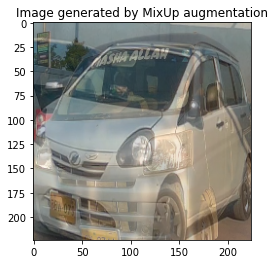

In [108]:
mixed_x, y_a, y_b, lam=mixup_data(image,label,1)
out1=np.moveaxis(mixed_x.numpy(),1,3)
plt.imshow(out1[1])
plt.title('Image generated by MixUp augmentation')    
plt.savefig('mixup_res.eps',bbox_inches='tight')

In [85]:
def cutmix(data,targets, alpha):
    #data, targets = batch

    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets = targets[indices]

    lam = np.random.beta(alpha, alpha)

    image_h, image_w = data.shape[2:]
    cx = np.random.uniform(0, image_w)
    cy = np.random.uniform(0, image_h)
    w = image_w * np.sqrt(1 - lam)
    h = image_h * np.sqrt(1 - lam)
    x0 = int(np.round(max(cx - w / 2, 0)))
    x1 = int(np.round(min(cx + w / 2, image_w)))
    y0 = int(np.round(max(cy - h / 2, 0)))
    y1 = int(np.round(min(cy + h / 2, image_h)))

    data[:, :, y0:y1, x0:x1] = shuffled_data[:, :, y0:y1, x0:x1]
    targets = (targets, shuffled_targets, lam)

    return data, targets

In [86]:
image=images[1:3].clone()
label=labels[1:3].clone()
data,target=cutmix(image,label,1)

In [87]:
inp=np.moveaxis(image.numpy(),1,3)

out2=np.moveaxis(data.numpy(),1,3)
out2.shape,inp.shape

((2, 224, 224, 3), (2, 224, 224, 3))

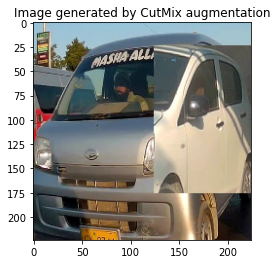

In [88]:
plt.imshow(out2[0])
plt.title('Image generated by CutMix augmentation')    
plt.savefig('cutmix_res.eps',bbox_inches='tight')

In [66]:
# fig,ax=plt.subplots(1,1)
# for i in range(2):
#     ax[i].imshow(out[i])
#     ax[i].set_xticks([])
#     ax[i].set_yticks([])
# plt.title('Image generated by CutMix augmentation',x=-0.15)    
# plt.savefig('cutmix_res.eps',bbox_inches='tight')

In [67]:
# # fig,ax=plt.subplots(1,1)
# # for i in range(1):
# #     ax[i].imshow(out[i])
# #     ax[i].set_xticks([])
# #     ax[i].set_yticks([])
# plt
# plt.title('Image generated by MixUp augmentation',x=-0.15)    
# plt.savefig('mixup_res.eps',bbox_inches='tight')

In [89]:
image=images[1:3].clone()
label=labels[1:3].clone()

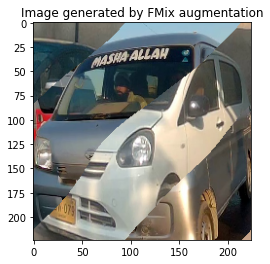

In [91]:
from fmixcode import FMix
fmix=FMix()
out3=fmix(image)
out3=np.moveaxis(out3.numpy(),1,3)
plt.imshow(out3[1])
plt.title('Image generated by FMix augmentation')    
plt.savefig('fmix_res.eps',bbox_inches='tight')

In [111]:
out=np.stack([out1[1],out2[0],out3[0]])
out.shape

(3, 224, 224, 3)

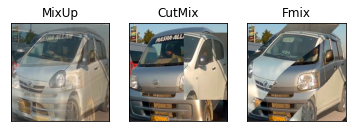

In [114]:
fig,ax=plt.subplots(1,3)
text=['MixUp','CutMix','Fmix']
for i in range(3):
    ax[i].imshow(out[i])
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_title('{}'.format(text[i]))    
plt.savefig('final msda.eps',bbox_inches='tight')

# densnet cmap